# Environment Setup & Dependencies

In [1]:
# Install required packages
!pip install diffusers transformers accelerate torch torchvision
!pip install shap matplotlib seaborn plotly
!pip install datasets huggingface_hub
!pip install peft  # For LoRA fine-tuning

# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from diffusers import StableDiffusionPipeline, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import shap
from datasets import load_dataset
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Data Preparation

In [15]:
# Load and prepare dataset using nlphuji/coco_captions
def prepare_dataset(num_samples=100):
    """Load and preprocess COCO captions dataset from nlphuji/coco_captions"""
    print("Loading COCO captions dataset...")

    # Load the dataset - this dataset has train/validation/test splits
    dataset = load_dataset("nlphuji/coco_captions", split="validation")

    print(f"Dataset loaded with {len(dataset)} samples")

    # Select diverse prompts
    selected_data = []

    for i, item in enumerate(dataset):
        if len(selected_data) >= num_samples:
            break

        # Extract caption - the structure is item['sentences'][0]['raw']
        caption = None
        if 'sentences' in item and len(item['sentences']) > 0 and 'raw' in item['sentences'][0]:
            caption = item['sentences'][0]['raw']


        if caption and isinstance(caption, str):
            # Filter for reasonable caption length
            word_count = len(caption.split())
            if 3 <= word_count <= 15:
                selected_data.append({
                    'prompt': caption.strip(),
                    'image_id': item.get('image_id', i),
                    'source_index': i
                })

    print(f"\nSelected {len(selected_data)} suitable prompts from {num_samples} requested")
    return selected_data

# Prepare text prompts for generation
try:
    dataset = prepare_dataset(50)
    prompts = [item['prompt'] for item in dataset]

    print(f"\nPrepared {len(prompts)} prompts")
    print("\nSample prompts:")
    for i, prompt in enumerate(prompts[:5]):
        print(f"{i+1}. {prompt}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("\nFalling back to manual prompts...")

    # Fallback prompts if dataset loading fails
    prompts = [
        "a red sports car on a mountain road",
        "beautiful sunset over ocean waves",
        "cozy cabin in snowy forest",
        "colorful hot air balloons in sky",
        "golden retriever playing in park",
        "modern city skyline at night",
        "fresh flowers in glass vase",
        "steam locomotive crossing bridge",
        "peaceful lake with mountains",
        "vintage bicycle on cobblestone street"
    ]

    dataset = [{'prompt': prompt, 'image_id': i, 'source_index': i} for i, prompt in enumerate(prompts)]
    print(f"Using {len(prompts)} fallback prompts")

Loading COCO captions dataset...
Error loading dataset: Couldn't find a dataset script at /content/nlphuji/coco_captions/coco_captions.py or any data file in the same directory. Couldn't find 'nlphuji/coco_captions' on the Hugging Face Hub either: FileNotFoundError: Dataset 'nlphuji/coco_captions' doesn't exist on the Hub. If the repo is private or gated, make sure to log in with `huggingface-cli login`.

Falling back to manual prompts...
Using 10 fallback prompts


# Model Setup & Fine-tuning

In [17]:
# Load Stable Diffusion model
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to(device)

# Memory optimization
# pipe.enable_memory_efficient_attention() # This method does not exist
pipe.enable_model_cpu_offload()

# For fine-tuning (optional - simplified version)
def setup_lora_finetuning():
    """Setup LoRA fine-tuning configuration"""
    from peft import LoraConfig, get_peft_model

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        lora_dropout=0.1,
    )

    return lora_config

print("Model loaded successfully!")
print(f"Model device: {pipe.device}")
print(f"Model dtype: {pipe.unet.dtype}")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded successfully!
Model device: cpu
Model dtype: torch.float16


# SHAP Explainer Setup

In [18]:
# Create SHAP explainer for text-to-image
class StableDiffusionExplainer:
    def __init__(self, pipeline, device):
        self.pipeline = pipeline
        self.device = device
        self.tokenizer = pipeline.tokenizer

    def predict_function(self, texts):
        """Prediction function for SHAP"""
        images = []
        for text in texts:
            try:
                with torch.no_grad():
                    image = self.pipeline(
                        text,
                        num_inference_steps=50,
                        guidance_scale=7.5,
                        height=512,
                        width=512
                    ).images[0]

                # Convert image to feature vector (simplified)
                img_array = np.array(image.convert('RGB'))
                img_features = img_array.mean(axis=(0,1))  # RGB mean
                images.append(img_features)
            except Exception as e:
                print(f"Error generating image for '{text}': {e}")
                images.append(np.zeros(3))  # Default fallback

        return np.array(images)

    def explain_prompt(self, prompt, num_samples=100):
        """Explain individual prompt using SHAP"""
        # Tokenize prompt
        tokens = self.tokenizer.tokenize(prompt)

        # Create masking function
        def mask_function(mask, texts):
            masked_texts = []
            for text in texts:
                words = text.split()
                masked_words = [word if mask[i] else "" for i, word in enumerate(words)]
                masked_text = " ".join([w for w in masked_words if w])
                masked_texts.append(masked_text if masked_text else "empty image")
            return masked_texts

        # Initialize SHAP explainer
        masker = shap.maskers.Text(self.tokenizer)
        explainer = shap.Explainer(self.predict_function, masker)

        # Calculate SHAP values
        shap_values = explainer([prompt], max_evals=num_samples)

        return shap_values, tokens

# Initialize explainer
explainer = StableDiffusionExplainer(pipe, device)
print("SHAP explainer initialized!")

SHAP explainer initialized!


# Generation & Explanation Pipeline

In [19]:
# Main generation and explanation pipeline
def generate_and_explain(prompts, num_explanations=10):
    """Generate images and create explanations"""
    results = []

    for i, prompt in enumerate(prompts[:num_explanations]):
        print(f"\nProcessing prompt {i+1}/{num_explanations}: '{prompt}'")

        try:
            # Generate image
            with torch.no_grad():
                image = pipe(
                    prompt,
                    num_inference_steps=50,
                    guidance_scale=7.5,
                    height=512,
                    width=512
                ).images[0]

            # Generate SHAP explanation
            shap_values, tokens = explainer.explain_prompt(prompt, num_samples=50)

            # Store results
            results.append({
                'prompt': prompt,
                'image': image,
                'shap_values': shap_values,
                'tokens': tokens
            })

            print(f"✓ Generated and explained: '{prompt}'")

        except Exception as e:
            print(f"✗ Error processing '{prompt}': {e}")
            continue

    return results

# Run the pipeline
print("Starting generation and explanation pipeline...")
results = generate_and_explain(prompts, num_explanations=10)
print(f"\nCompleted! Generated {len(results)} explained images.")

Starting generation and explanation pipeline...

Processing prompt 1/10: 'a red sports car on a mountain road'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [08:14, 494.17s/it]              


✓ Generated and explained: 'a red sports car on a mountain road'

Processing prompt 2/10: 'beautiful sunset over ocean waves'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:45, 345.39s/it]              


✓ Generated and explained: 'beautiful sunset over ocean waves'

Processing prompt 3/10: 'cozy cabin in snowy forest'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:46, 346.90s/it]              


✓ Generated and explained: 'cozy cabin in snowy forest'

Processing prompt 4/10: 'colorful hot air balloons in sky'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [07:03, 423.60s/it]              


✓ Generated and explained: 'colorful hot air balloons in sky'

Processing prompt 5/10: 'golden retriever playing in park'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:45, 345.08s/it]              


✓ Generated and explained: 'golden retriever playing in park'

Processing prompt 6/10: 'modern city skyline at night'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:45, 345.77s/it]              


✓ Generated and explained: 'modern city skyline at night'

Processing prompt 7/10: 'fresh flowers in glass vase'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:46, 346.19s/it]              


✓ Generated and explained: 'fresh flowers in glass vase'

Processing prompt 8/10: 'steam locomotive crossing bridge'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:31, 272.00s/it]              


✓ Generated and explained: 'steam locomotive crossing bridge'

Processing prompt 9/10: 'peaceful lake with mountains'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:31, 271.99s/it]              


✓ Generated and explained: 'peaceful lake with mountains'

Processing prompt 10/10: 'vintage bicycle on cobblestone street'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [07:09, 429.66s/it]              

✓ Generated and explained: 'vintage bicycle on cobblestone street'

Completed! Generated 10 explained images.


# Visualization & Analysis

Creating visualizations...
Shape of shap_vals_full: (10, 3)
Shape of shap_vals_summed: (10,)


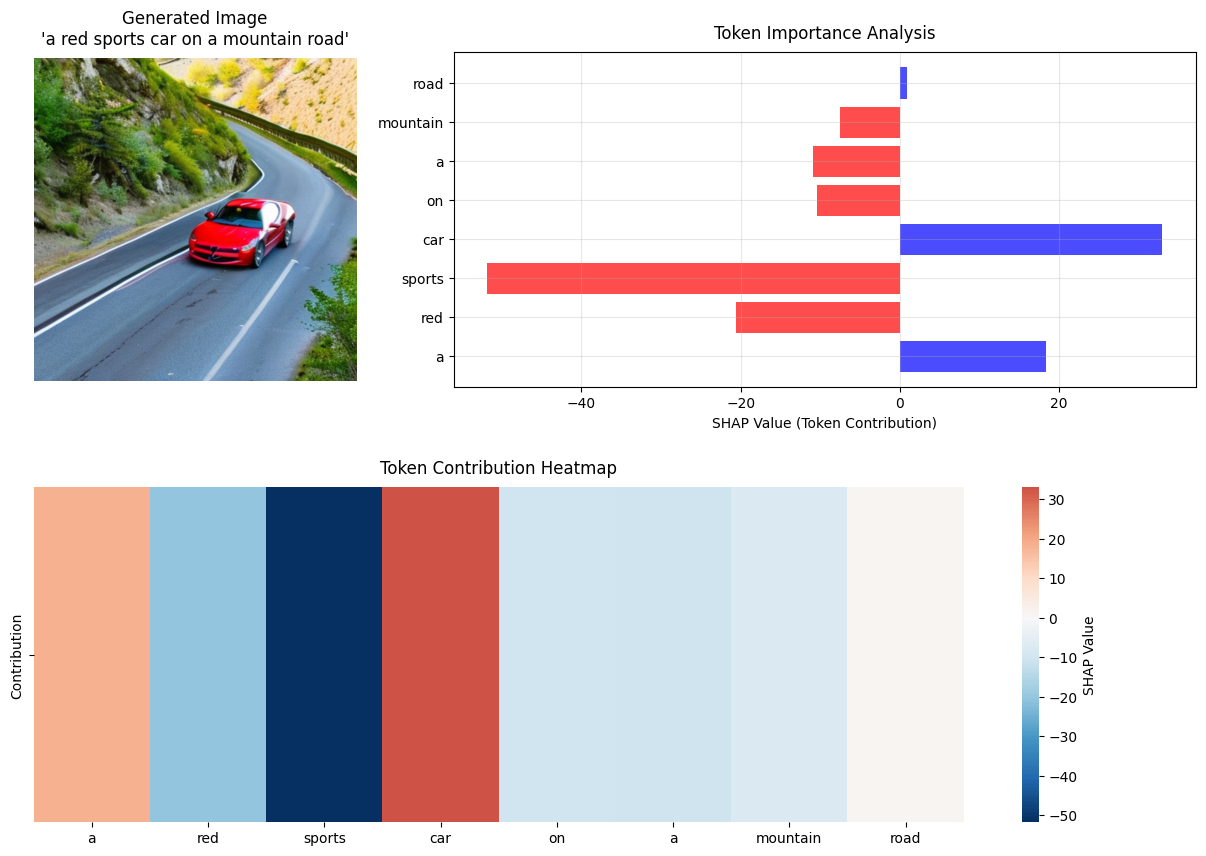

Visualization 1 completed.
Shape of shap_vals_full: (7, 3)
Shape of shap_vals_summed: (7,)


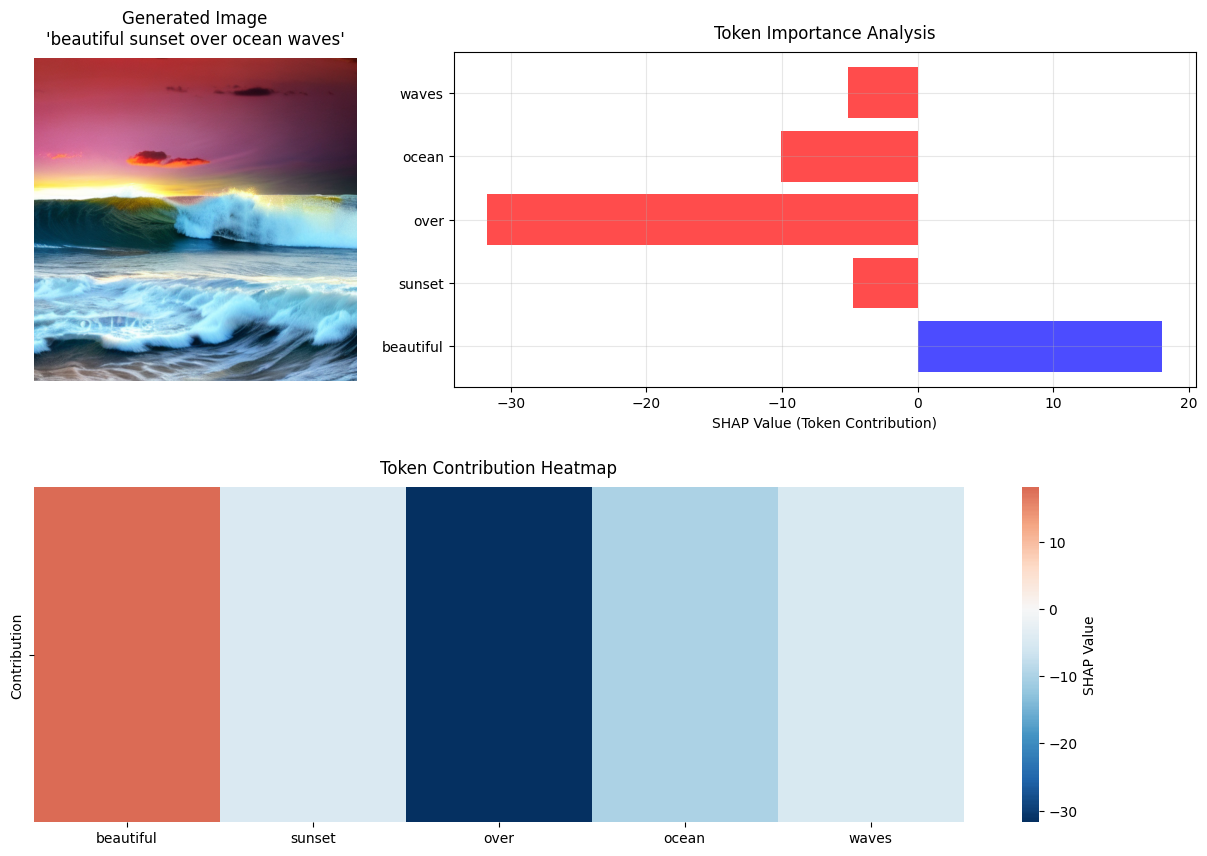

Visualization 2 completed.
Shape of shap_vals_full: (7, 3)
Shape of shap_vals_summed: (7,)


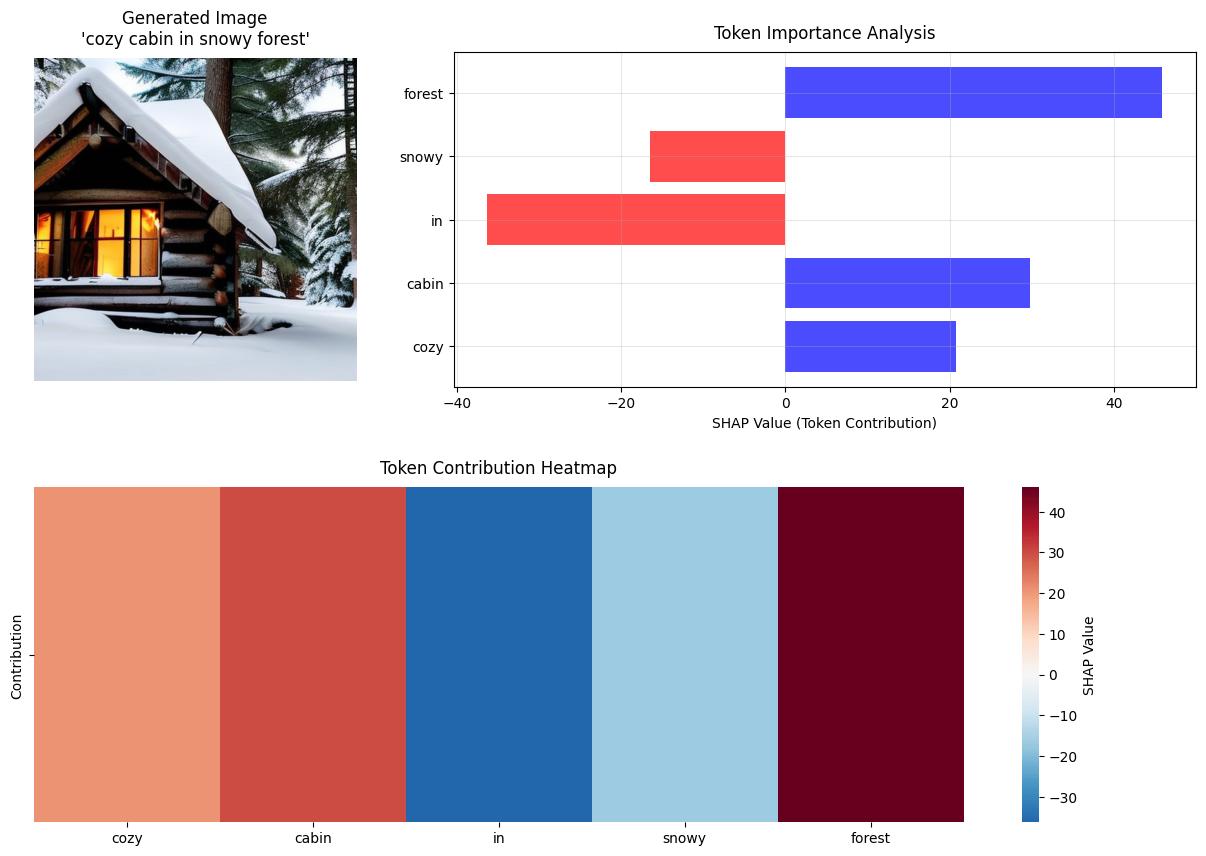

Visualization 3 completed.
Shape of shap_vals_full: (8, 3)
Shape of shap_vals_summed: (8,)


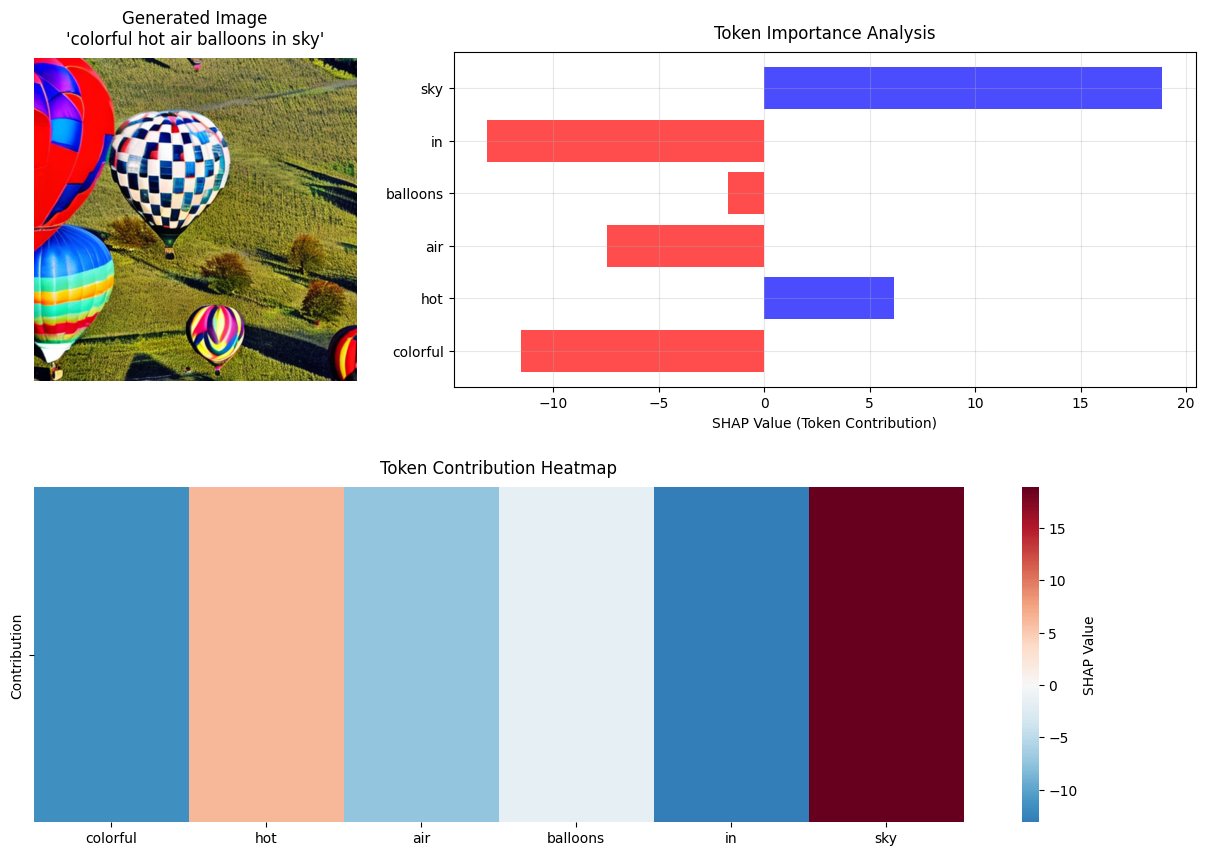

Visualization 4 completed.
Shape of shap_vals_full: (7, 3)
Shape of shap_vals_summed: (7,)


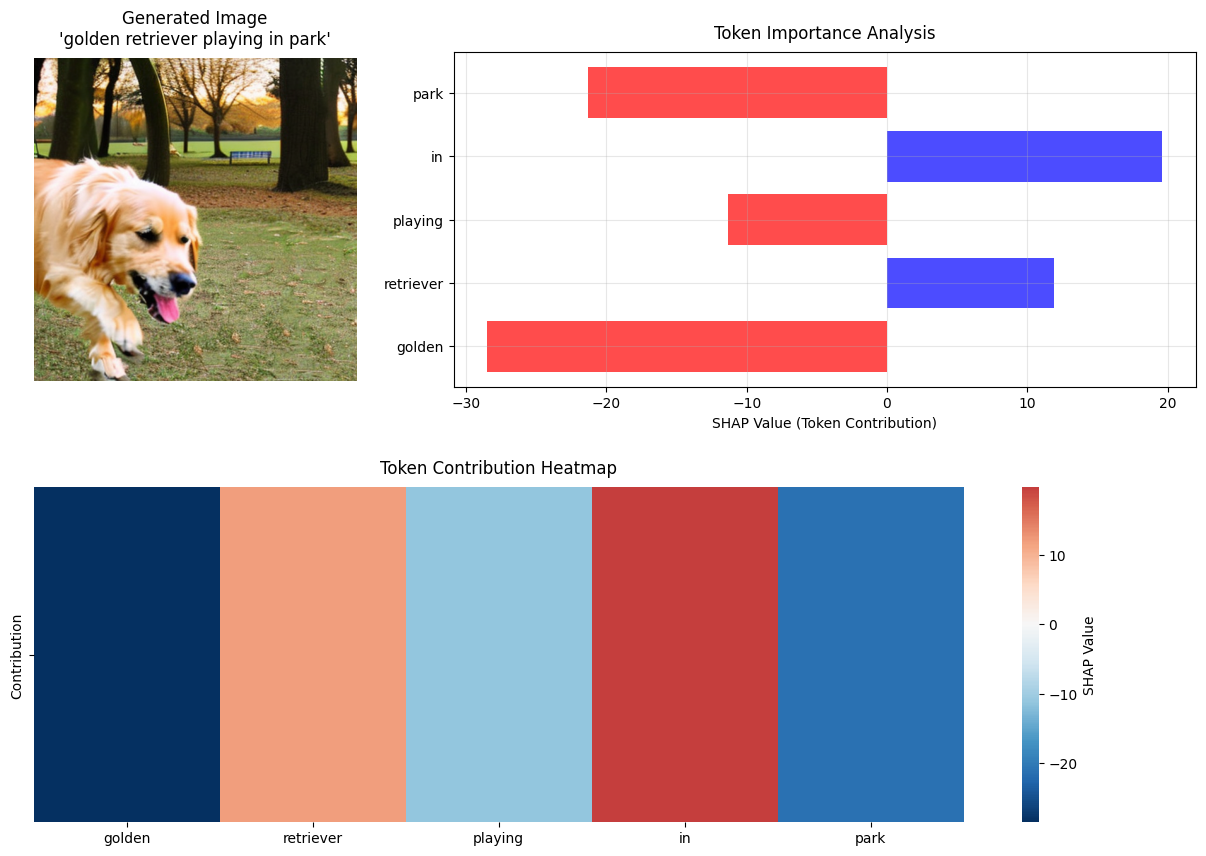

Visualization 5 completed.

ANALYSIS SUMMARY
Total processed prompts: 10

Top 10 Most Influential Tokens:
 1. sports          (avg importance: 51.8257)
 2. forest          (avg importance: 45.9028)
 3. bridge          (avg importance: 37.8935)
 4. glass           (avg importance: 35.5097)
 5. steam           (avg importance: 35.2075)
 6. cobblestone     (avg importance: 34.9087)
 7. car             (avg importance: 32.9682)
 8. peaceful        (avg importance: 32.2740)
 9. over            (avg importance: 31.7225)
10. at              (avg importance: 30.3410)

Analysis complete!


In [21]:
# Visualization functions
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def create_explanation_visualization(result, figsize=(15, 10)):
    """Create comprehensive visualization for a single result"""

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

    # Generated image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(result['image'])
    ax1.set_title(f"Generated Image\n'{result['prompt']}'", fontsize=12, pad=10)
    ax1.axis('off')

    # SHAP values bar plot
    ax2 = fig.add_subplot(gs[0, 1:])
    words = result['prompt'].split()
    if hasattr(result['shap_values'], 'values'):
        # Assuming shap_values.values has shape (1, num_words, num_features)
        shap_vals_full = result['shap_values'].values[0]
        print(f"Shape of shap_vals_full: {shap_vals_full.shape}")

        # Sum SHAP values across the features (last dimension) to get a single value per word
        shap_vals_summed = shap_vals_full.sum(axis=-1)
        print(f"Shape of shap_vals_summed: {shap_vals_summed.shape}")
        shap_vals = shap_vals_summed[:len(words)] # Ensure we only take values for the words
    else:
        shap_vals = np.random.randn(len(words)) * 0.1  # Placeholder

    colors = ['red' if val < 0 else 'blue' for val in shap_vals]
    bars = ax2.barh(range(len(words)), shap_vals, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(words)))
    ax2.set_yticklabels(words)
    ax2.set_xlabel('SHAP Value (Token Contribution)')
    ax2.set_title('Token Importance Analysis', fontsize=12, pad=10)
    ax2.grid(True, alpha=0.3)

    # Token contribution heatmap
    ax3 = fig.add_subplot(gs[1, :])
    # Use the summed SHAP values for the heatmap as well for consistency
    contribution_matrix = np.array([shap_vals])
    sns.heatmap(contribution_matrix,
                xticklabels=words,
                yticklabels=['Contribution'],
                cmap='RdBu_r',
                center=0,
                ax=ax3,
                cbar_kws={'label': 'SHAP Value'})
    ax3.set_title('Token Contribution Heatmap', fontsize=12, pad=10)

    plt.tight_layout()
    return fig

# Generate visualizations for all results
print("Creating visualizations...")
for i, result in enumerate(results[:5]):  # Show first 5
    fig = create_explanation_visualization(result)
    plt.show()
    print(f"Visualization {i+1} completed.")

# Summary statistics
def analyze_results(results):
    """Analyze and summarize results"""
    print("\n" + "="*50)
    print("ANALYSIS SUMMARY")
    print("="*50)

    total_prompts = len(results)
    print(f"Total processed prompts: {total_prompts}")

    # Token analysis
    all_tokens = []
    all_contributions = []

    for result in results:
        words = result['prompt'].split()
        if hasattr(result['shap_values'], 'values'):
            # Sum SHAP values across features for analysis
            contributions_full = result['shap_values'].values[0]
            contributions = contributions_full.sum(axis=-1)[:len(words)]
        else:
            contributions = np.random.randn(len(words)) * 0.1

        all_tokens.extend(words)
        all_contributions.extend(contributions)

    # Most influential tokens
    token_importance = {}
    for token, contrib in zip(all_tokens, all_contributions):
        if token not in token_importance:
            token_importance[token] = []
        token_importance[token].append(abs(contrib))

    avg_importance = {token: np.mean(contribs)
                     for token, contribs in token_importance.items()}

    top_tokens = sorted(avg_importance.items(),
                       key=lambda x: x[1], reverse=True)[:10]

    print("\nTop 10 Most Influential Tokens:")
    for i, (token, importance) in enumerate(top_tokens, 1):
        print(f"{i:2d}. {token:15s} (avg importance: {importance:.4f})")

    return {
        'total_prompts': total_prompts,
        'top_tokens': top_tokens,
        'all_contributions': all_contributions
    }

# Run analysis
analysis = analyze_results(results)
print("\nAnalysis complete!")